In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
class KNearestNeighbors:
    """
    K-Nearest Neighbors (KNN) classifier.

    Attributes:
        k (int): The number of neighbors to consider.
    """
    def __init__(self, k=3):
        """
        Initializes the KNN classifier.

        Args:
            k (int, optional): The number of neighbors. Defaults to 3.
        """
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Trains the KNN classifier.  Note that KNN is a lazy learner, so this method
        simply stores the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Predicts the class labels for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted class labels, shape (n_samples,).
        """
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        """
        Predicts the class label for a single data point.

        Args:
            x (ndarray): A single data point with shape (n_features,).

        Returns:
            int: The predicted class label.
        """
        # Compute distances between x and all training points
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]

        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Determine most common label among the k neighbors
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]  # Return the label

    def _euclidean_distance(self, x1, x2):
        """
        Computes the Euclidean distance between two data points.

        Args:
            x1 (ndarray): The first data point, shape (n_features,).
            x2 (ndarray): The second data point, shape (n_features,).

        Returns:
            float: The Euclidean distance between x1 and x2.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def score(self, X, y):
        """
        Calculates the accuracy of the model on the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The true labels, shape (n_samples,).

        Returns:
            float: The accuracy of the model.
        """
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y) / len(y)
        return accuracy

In [9]:
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Select input features and target
features = ['Barrel%', 'EV', 'LA']
target = 'wRC+'

X = df[features].values
y = df[target].values

# Normalize the features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [11]:
knn = KNearestNeighbors(k=5)
knn.fit(X_train, y_train)

# Predictions and evaluation
y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 27.49
MAE: 21.62


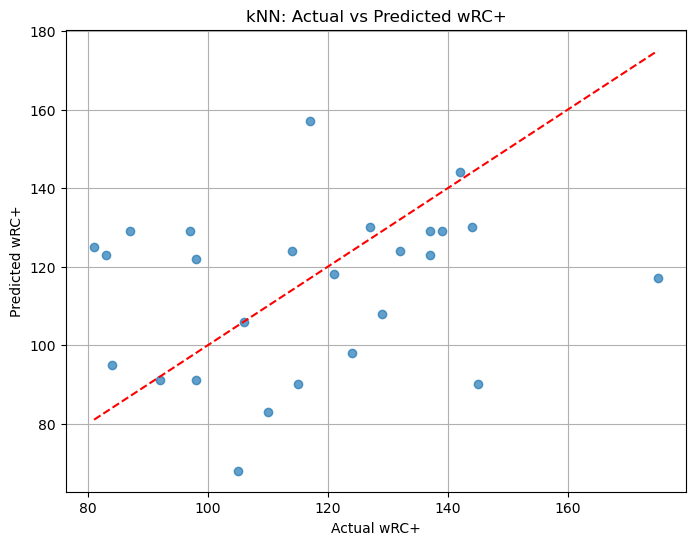

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual wRC+")
plt.ylabel("Predicted wRC+")
plt.title("kNN: Actual vs Predicted wRC+")
plt.grid(True)
plt.show()

This scatterplot compares the actual wRC+ values to the predicted values generated by the k-Nearest Neighbors model. The red dashed line represents a perfect prediction, where predicted equals actual. While the predictions generally follow the overall trend, there is noticeable variance, especially for a couple of the players with extremely high actual wRC+ values. The model tends to underpredict elite performances and overpredict for below-average hitters, suggesting a regression-to-the-mean effect. This behavior is expected for kNN models, especially when the true relationship between features and target is nonlinear or when the training data is sparse in certain regions of feature space.

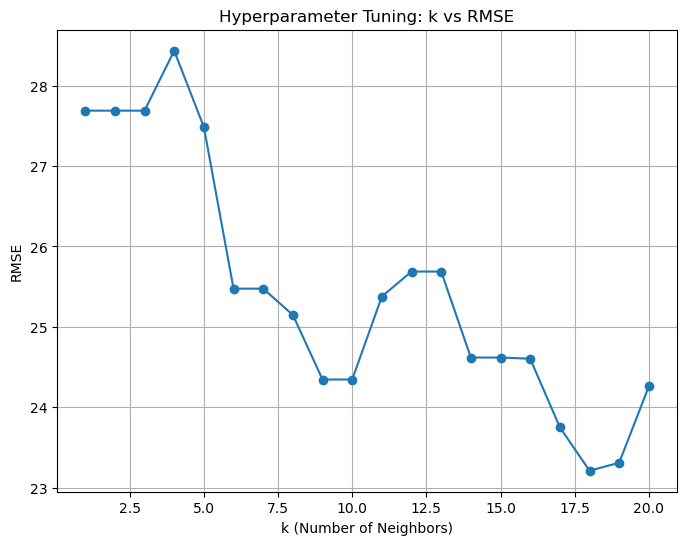

Best k: 18, with RMSE = 23.21


In [15]:
k_values = list(range(1, 21))
rmse_values = []

for k in k_values:
    knn_k = KNearestNeighbors(k=k)
    knn_k.fit(X_train, y_train)
    y_pred_k = knn_k.predict(X_test)
    rmse_k = np.sqrt(mean_squared_error(y_test, y_pred_k))
    rmse_values.append(rmse_k)

plt.figure(figsize=(8, 6))
plt.plot(k_values, rmse_values, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("RMSE")
plt.title("Hyperparameter Tuning: k vs RMSE")
plt.grid(True)
plt.show()

best_k = k_values[np.argmin(rmse_values)]
print(f"Best k: {best_k}, with RMSE = {min(rmse_values):.2f}")

To find the optimal number of neighbors, we evaluated model performance across a range of k values from 1 to 20. The plot shows that RMSE decreases steadily as k increases, with a few fluctuations due to local variance. The minimum RMSE of 23.21 occurs at k = 18, making it the best choice for this dataset. Smaller k values introduce more noise, while larger k values offer more stable, averaged predictions. However, setting k too high could also dilute important signal from closer neighbors, so this tuning step is crucial to strike the right balance between bias and variance.

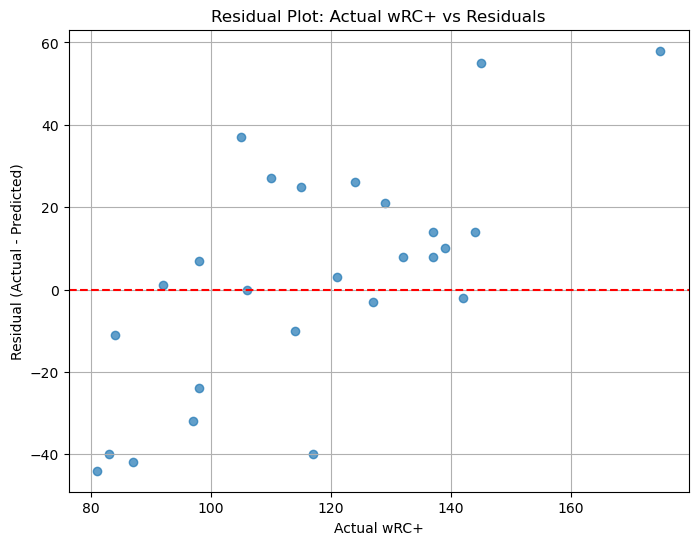

In [17]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual wRC+")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot: Actual wRC+ vs Residuals")
plt.grid(True)
plt.show()

This residual plot displays the difference between actual and predicted wRC+ values across the full range of actual outcomes. Ideally, we'd want the residuals to be randomly scattered around zero, with no clear patterns — but here, a noticeable trend emerges. For players with lower actual wRC+ (less than 100), residuals are mostly negative, indicating consistent overprediction. In contrast, for players with higher wRC+ (greater than 120), residuals become strongly positive, meaning the model is underpredicting elite performances. This non-random pattern suggests that the model isn't fully capturing the nonlinearity or feature interactions that separate average from elite hitters. Incorporating polynomial features or switching to a more flexible model might help reduce this bias.